### Fine tuning Initial

In [1]:
import numpy as np
import pandas as pd
import torch, torchvision
import matplotlib.pyplot as plt

### loading data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("veeralakrishna/200-bird-species-with-11788-images")

print("Path to dataset files:", path)

In [ ]:
import tarfile
import os

# Path to the downloaded .tgz file
tgz_path = os.path.join(path, 'CUB_200_2011.tgz')

# Directory where the contents will be extracted
extract_dir = os.path.join(path, 'extracted_dataset')

# Extract the .tgz file
with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path=extract_dir)

print(f"Dataset extracted to: {extract_dir}")

In [ ]:
image_dir = os.path.join(extract_dir,'CUB_200_2011/images')

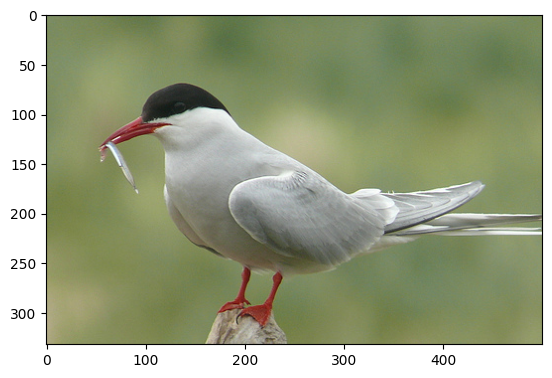

In [ ]:
arctic_ten = os.path.join(image_dir, '141.Artic_Tern')
example_im = os.path.join(arctic_ten, 'Artic_Tern_0090_143583.jpg')

img = plt.imread(example_im)
plt.imshow(img)

## create the test and train data

In [ ]:
image_paths = []

images = os.path.join(extract_dir,'CUB_200_2011/images.txt')

with open(images, 'r') as images_file:
  for line2 in images_file:
    image_paths.append(line2.split()[1])

print(len(image_paths))


11788


In [8]:
from torch.utils.data import random_split

In [9]:
train_datapaths, val_test_datapaths = random_split(image_paths, [int(0.7*len(image_paths)), len(image_paths)-int(0.7*len(image_paths))])

In [10]:
len(train_datapaths)

8251

In [11]:
test_datapath, val_datapaths = random_split(val_test_datapaths, [int(0.5*len(val_test_datapaths)), len(val_test_datapaths)-int(0.5*len(val_test_datapaths))])
print(len(test_datapath))
print(len(val_datapaths))

1768
1769


torch.Size([3, 349, 500])


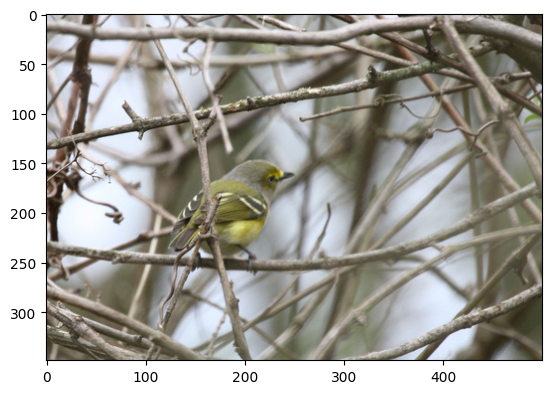

In [12]:
from torchvision.io import read_image

im = read_image(image_dir+"/"+train_datapaths[1])
print(im.shape)
plt.imshow(im.permute(1,2,0))

In [13]:
# the class of the bird species
int(train_datapaths[1].split('/')[0].split('.')[0])

156

### creating dataset class and dataloader object

In [14]:
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

In [ ]:
import albumentations as Album
from albumentations.pytorch import ToTensorV2

In [ ]:
class Bird_dataset(Dataset):
  def __init__(self, paths, transforms=None):
    super().__init__()
    self.paths = paths
    self.transform = transforms

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    image = read_image(image_dir+"/"+self.paths[idx])

    if self.transform:
      image = image.permute(1, 2, 0).numpy()
      image = self.transform(image=image)['image']

      # Ensure 3 channels after transformations
    if image.shape[0] == 1:  # If grayscale, convert to RGB
        image = image.repeat(3, 1, 1)

    label = torch.tensor(int(self.paths[idx].split('/')[0].split('.')[0])- 1)
    return image, label

### utilizing albumentations transformations

In [ ]:
train_transform = Album.Compose([
    Album.HorizontalFlip(p=0.5),
    Album.RandomBrightnessContrast(p=0.2),
    Album.ShiftScaleRotate(p=0.2, shift_limit=0.05, scale_limit=0.05, rotate_limit=15),
    Album.Resize(256,256),
    Album.RandomCrop(224, 224),
    Album.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.3),
    Album.GaussianBlur(blur_limit=(3, 7), p=0.2),
    Album.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.1),
    Album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [18]:
validation_transform = Album.Compose([
    Album.Resize(256, 256),
    Album.CenterCrop(height=224, width=224),
    Album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

### creating  dataset and dataloader object

In [19]:
train_dataset = Bird_dataset(train_datapaths,transforms=train_transform)
val_dataset = Bird_dataset(val_datapaths, transforms=validation_transform)
test_dataset = Bird_dataset(test_datapath, transforms=validation_transform)


In [20]:
print(train_dataset.transform)

Compose([
  HorizontalFlip(p=0.5),
  RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, ensure_safe_range=False),
  ShiftScaleRotate(p=0.2, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15.0, 15.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  RandomCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  ColorJitter(p=0.3, brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1)),
  GaussianBlur(p=0.2, blur_limit=(3, 7), sigma_limit=(0.5, 3.0)),
  CLAHE(p=0.1, clip_limit=(1.0, 2.0), tile_grid_size=(8, 8)),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, norma

In [21]:
print(val_dataset.transform)

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  CenterCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [22]:
print(test_dataset.transform)

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  CenterCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [23]:
train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size= 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= 64, shuffle=True)

In [24]:
train_dataset[1][1] +1

tensor(156)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5630251..2.2914162].


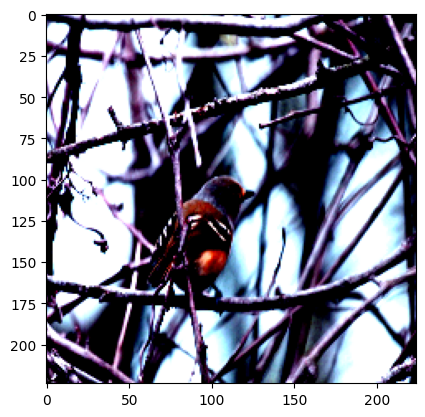

In [25]:
plt.imshow(train_dataset[1][0].permute(1,2,0))

In [26]:
train_dataset[1][0]

tensor([[[-1.4843, -1.3130, -0.6452,  ...,  1.3413,  1.4440,  1.4954],
         [-1.4843, -1.2959, -0.6452,  ...,  1.4954,  1.5982,  1.6324],
         [-1.4843, -1.2959, -0.6794,  ...,  1.5468,  1.6324,  1.6324],
         ...,
         [-0.4397, -0.3541, -0.2342,  ..., -0.4568, -0.5082, -0.4397],
         [-0.3712, -0.2856, -0.1657,  ..., -0.4911, -0.5938, -0.6794],
         [-0.2684, -0.1828, -0.0972,  ..., -0.6794, -0.6623, -0.4739]],

        [[-1.3880, -1.2479, -0.6877,  ...,  1.6583,  1.7808,  1.8683],
         [-1.3880, -1.2479, -0.6877,  ...,  1.8158,  1.8859,  1.9384],
         [-1.3880, -1.2129, -0.6877,  ...,  1.8333,  1.9209,  1.9559],
         ...,
         [-0.4251, -0.2675, -0.2150,  ..., -0.4076, -0.5476, -0.5126],
         [-0.3725, -0.2150, -0.1099,  ..., -0.5126, -0.6702, -0.7927],
         [-0.2675, -0.0924, -0.0749,  ..., -0.7402, -0.7577, -0.6001]],

        [[-1.1596, -1.0376, -0.6018,  ...,  2.0300,  2.1694,  2.1694],
         [-1.1596, -1.0376, -0.6193,  ...,  2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9064131].


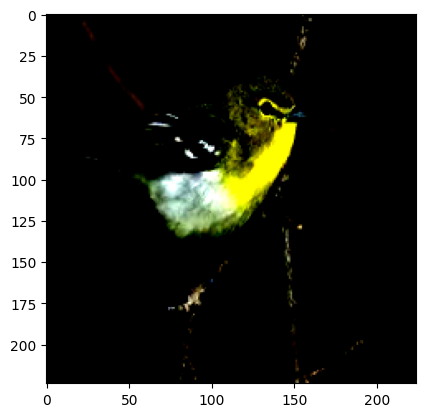

In [27]:
plt.imshow(val_dataset[1][0].permute(1,2,0))

In [28]:
val_dataset[1][1]+1

tensor(157)

In [29]:
for x in train_dataloader:
  print(x[0].shape)
  break

torch.Size([64, 3, 224, 224])


### Using mobilenet_v2 as pretrained model

In [30]:
import torchvision.models as models
import torch.nn as nn

In [31]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [32]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

for layer in model.features[13:]:
    for param in layer.parameters():
        param.requires_grad = True


In [ ]:
model.classifier = nn.Sequential(
    nn.Dropout(0.3, inplace=False),
    nn.Linear(model.last_channel, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3, inplace=False),
    nn.Linear(512, 200)
)

### training loop

In [36]:
from torch.optim import AdamW
from tqdm import tqdm

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = AdamW([
    {'params': model.features[13:].parameters(),  'weight_decay': 5e-5},
    {'params': model.classifier.parameters(), 'weight_decay':5e-4},
])

In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3) # Reduce LR if val loss plateaus

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
state_dict = torch.load('weights/smodel_r1.pth')

model.load_state_dict(state_dict)


<All keys matched successfully>

In [49]:
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
for epoch in range(18):
  total_correct_train = 0  # Accumulate correct predictions for training
  total_samples_train = 0  # Accumulate total samples for training

  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model.forward(x)

    predicted_labels = y_pred.argmax(dim=1)
    total_correct_train += (predicted_labels == y).sum().item()  # Add correct predictions
    total_samples_train += len(y)  # Add total samples in the batch

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  train_accuracy = total_correct_train / total_samples_train
  with torch.no_grad():
    acc = []
    for x, y in val_dataloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model.forward(x).argmax(-1)
      acc.append((y_pred == y).sum().item()/len(y))
  print("epoch:", epoch," loss:",loss.item(), " acc:",np.mean(acc), "training acc:", train_accuracy)
  scheduler.step(loss)

  0%|          | 0/129 [00:00<?, ?it/s]

100%|██████████| 129/129 [09:32<00:00,  4.43s/it]


epoch: 0  loss: 2.2182021141052246  acc: 0.8882567508710801 training acc: 0.8734698824384923


100%|██████████| 129/129 [06:44<00:00,  3.14s/it]


epoch: 1  loss: 2.282989978790283  acc: 0.8924079921602788 training acc: 0.8956490122409405


100%|██████████| 129/129 [06:35<00:00,  3.07s/it]


epoch: 2  loss: 2.037290334701538  acc: 0.8874537238675958 training acc: 0.9077687553023875


100%|██████████| 129/129 [07:43<00:00,  3.59s/it]


epoch: 3  loss: 2.0163464546203613  acc: 0.8791920731707317 training acc: 0.9171009574597019


100%|██████████| 129/129 [07:15<00:00,  3.38s/it]


epoch: 4  loss: 1.976595401763916  acc: 0.8896858667247386 training acc: 0.9270391467700885


100%|██████████| 129/129 [07:44<00:00,  3.60s/it]


epoch: 5  loss: 1.866614580154419  acc: 0.8812472778745645 training acc: 0.9380681129560053


100%|██████████| 129/129 [07:37<00:00,  3.54s/it]


epoch: 6  loss: 1.8727706670761108  acc: 0.8874537238675958 training acc: 0.9384317052478487


100%|██████████| 129/129 [07:20<00:00,  3.41s/it]


epoch: 7  loss: 1.8177446126937866  acc: 0.8829894381533101 training acc: 0.945703551084717


100%|██████████| 129/129 [07:14<00:00,  3.37s/it]


epoch: 8  loss: 1.806856632232666  acc: 0.8824994555749129 training acc: 0.9460671433765604


100%|██████████| 129/129 [07:19<00:00,  3.41s/it]


epoch: 9  loss: 1.895140528678894  acc: 0.8832344294425087 training acc: 0.9492182765725367


100%|██████████| 129/129 [08:09<00:00,  3.79s/it]


epoch: 10  loss: 1.7518110275268555  acc: 0.8758438588850174 training acc: 0.9553993455338747


100%|██████████| 129/129 [08:22<00:00,  3.90s/it]


epoch: 11  loss: 1.9053046703338623  acc: 0.8707126524390244 training acc: 0.9564901224094049


100%|██████████| 129/129 [07:37<00:00,  3.55s/it]


epoch: 12  loss: 1.7442727088928223  acc: 0.8703996080139372 training acc: 0.9595200581747667


100%|██████████| 129/129 [07:18<00:00,  3.40s/it]


epoch: 13  loss: 1.8066576719284058  acc: 0.8588577961672473 training acc: 0.9601260453278391


100%|██████████| 129/129 [08:00<00:00,  3.73s/it]


epoch: 14  loss: 1.720801591873169  acc: 0.866915287456446 training acc: 0.9609744273421403


100%|██████████| 129/129 [08:21<00:00,  3.89s/it]


epoch: 15  loss: 1.7619229555130005  acc: 0.8723867595818815 training acc: 0.9643679553993455


100%|██████████| 129/129 [06:58<00:00,  3.24s/it]


epoch: 16  loss: 1.7307018041610718  acc: 0.8705765461672473 training acc: 0.9596412556053812


100%|██████████| 129/129 [06:45<00:00,  3.15s/it]


epoch: 17  loss: 1.7626696825027466  acc: 0.8539035278745645 training acc: 0.9607320324809114


Highest seen accuracy is 89.24% on validation 97% on training. accuracy has been fluctuating could show potential problem of overfitting

In [46]:
torch.save(model.state_dict(), 'weights/smodel_r2.pth')  # Save model

In [ ]:
state_dict = torch.load('weights/smodel_r2.pth')

model.load_state_dict(state_dict)

model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [53]:
# for 15 epochs or until 85 percent accuracy
for epoch in range(18):
  total_correct_train = 0  # Accumulate correct predictions for training
  total_samples_train = 0  # Accumulate total samples for training

  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model.forward(x)

    predicted_labels = y_pred.argmax(dim=1)
    total_correct_train += (predicted_labels == y).sum().item()  # Add correct predictions
    total_samples_train += len(y)  # Add total samples in the batch

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  train_accuracy = total_correct_train / total_samples_train
  with torch.no_grad():
    acc = []
    for x, y in val_dataloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model.forward(x).argmax(-1)
      acc.append((y_pred == y).sum().item()/len(y))
  print("epoch:", epoch," loss:",loss.item(), " acc:",np.mean(acc), "training acc:", train_accuracy)
  scheduler.step(loss)

100%|██████████| 129/129 [07:34<00:00,  3.53s/it]


epoch: 0  loss: 0.10005053132772446  acc: 0.8918499564459931 training acc: 0.9807296085322991


100%|██████████| 129/129 [07:23<00:00,  3.44s/it]


epoch: 1  loss: 0.12000802904367447  acc: 0.8844185540069687 training acc: 0.9830323597139741


100%|██████████| 129/129 [07:28<00:00,  3.48s/it]


epoch: 2  loss: 0.047303516417741776  acc: 0.8868276350174217 training acc: 0.9867894800630227


100%|██████████| 129/129 [07:20<00:00,  3.41s/it]


epoch: 3  loss: 0.13217908143997192  acc: 0.8844185540069687 training acc: 0.9849715186038056


100%|██████████| 129/129 [07:15<00:00,  3.38s/it]


epoch: 4  loss: 0.04460560530424118  acc: 0.8890597778745645 training acc: 0.9870318749242516


100%|██████████| 129/129 [07:09<00:00,  3.33s/it]


epoch: 5  loss: 0.030788395553827286  acc: 0.8896178135888502 training acc: 0.9887286389528542


100%|██████████| 129/129 [07:14<00:00,  3.37s/it]


epoch: 6  loss: 0.06286002695560455  acc: 0.8862695993031359 training acc: 0.987637862077324


100%|██████████| 129/129 [07:14<00:00,  3.37s/it]


epoch: 7  loss: 0.04079081118106842  acc: 0.8922310540069687 training acc: 0.9880014543691674


100%|██████████| 129/129 [07:13<00:00,  3.36s/it]


epoch: 8  loss: 0.05333910882472992  acc: 0.8931429660278746 training acc: 0.9906677978426858


100%|██████████| 129/129 [07:15<00:00,  3.37s/it]


epoch: 9  loss: 0.04578058421611786  acc: 0.8862695993031359 training acc: 0.9886074415222398


100%|██████████| 129/129 [07:14<00:00,  3.37s/it]


epoch: 10  loss: 0.010767986997961998  acc: 0.8892367160278746 training acc: 0.98969821839777


100%|██████████| 129/129 [07:13<00:00,  3.36s/it]


epoch: 11  loss: 0.23188859224319458  acc: 0.8940820993031359 training acc: 0.9906677978426858


100%|██████████| 129/129 [07:28<00:00,  3.48s/it]


epoch: 12  loss: 0.03309159725904465  acc: 0.8899989111498259 training acc: 0.9907889952733002


100%|██████████| 129/129 [07:22<00:00,  3.43s/it]


epoch: 13  loss: 0.09809283912181854  acc: 0.8918499564459931 training acc: 0.989455823536541


100%|██████████| 129/129 [07:12<00:00,  3.35s/it]


epoch: 14  loss: 0.028871312737464905  acc: 0.8932110191637631 training acc: 0.992000969579445


100%|██████████| 129/129 [07:15<00:00,  3.38s/it]


epoch: 15  loss: 0.06367771327495575  acc: 0.8927890897212544 training acc: 0.9898194158283844


100%|██████████| 129/129 [07:18<00:00,  3.40s/it]


epoch: 16  loss: 0.028683170676231384  acc: 0.8951301175958187 training acc: 0.9924857593019027


100%|██████████| 129/129 [07:16<00:00,  3.39s/it]


epoch: 17  loss: 0.08896900713443756  acc: 0.8868276350174217 training acc: 0.9924857593019027


In [54]:
torch.save(model.state_dict(), 'weights/smodel_r2.pth')  # Save model

retraining with increasing weight decay in optimizer to reduce overfitting from 5e-4 to 7e^4 and 5e^5 to 7e^5 on colab notebook